In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
mpl.style.use('seaborn')
plt.rcParams['axes.facecolor'] = '#f0f4f7'
plt.rc('legend', frameon=True,fancybox=True, framealpha=1)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

blue = '#4C72B0'
green = '#55A868'
red = '#C44E52'
purple = '#8172B2'
yellow = '#CCB974'
lightblue = '#64B5CD'

%load_ext autoreload
%autoreload 2


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


from os import path
import os
import sys
import platform
import qgrid

# Binary Format

In [13]:
# windows
#openephys_dir = r"C:\maxland_RECORDING\openephys\2021-02-19_15-54-34\Record Node 101\experiment1\recording1"

# mac
openephys_dir = "/Users/max/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/2 VR Setup/Software/PyBpod Environments/maxland_test_setup/openephys/2021-02-19_15-54-34/Record Node 101/experiment1/recording1"

pybpod_session = "20210219-155417"

# windows
#pybpod_root = r"C:\maxland_RECORDING"

# mac
pybpod_root = "/Users/max/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/2 VR Setup/Software/PyBpod Environments/maxland_test_setup"

In [14]:
combined_df = get_sync(openephys_dir,pybpod_root,pybpod_session)
qgrid.show_grid(combined_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

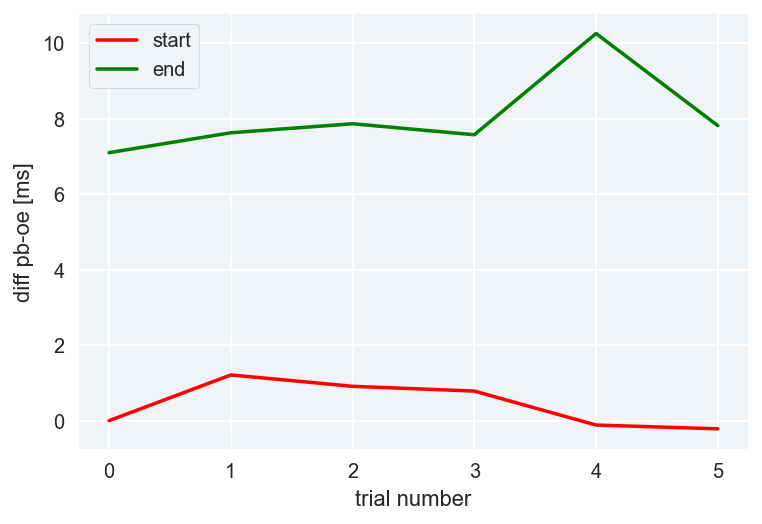

In [18]:
fig,ax = plt_start_stop_dif(combined_df,)

## Load OpenEphys Events

In [6]:
oe_events_df = load_oo_events(openephys_dir)
qgrid.show_grid(oe_events_df)


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Plot

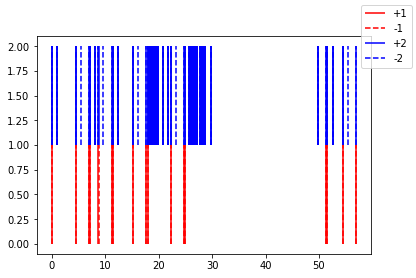

In [7]:
fig,ax = plt.subplots()
ax.vlines(oe_events_df.loc[oe_events_df.event==1,"s_relativ"], 0,1, label='+1', color ='r')
ax.vlines(oe_events_df.loc[oe_events_df.event==-1,"s_relativ"], 0,1, label='-1', color ='r',linestyle='--')

ax.vlines(oe_events_df.loc[oe_events_df.event==2,"s_relativ"], 1,2, label='+2', color ='b')
ax.vlines(oe_events_df.loc[oe_events_df.event==-2,"s_relativ"], 1,2, label='-2', color ='b',linestyle='--')

#ax.vlines(ch2, 0,1, label='2', color='grey', alpha=0.5)
#ax.vlines(ch5, 0,1, label='5',color='grey', alpha=0.5)
fig.legend()

## Load PyBpod Events

In [8]:
pb_events_df = load_bp_events(pybpod_root,pybpod_session)

selector = np.logical_or(pb_events_df.TYPE=="TRANSITION",pb_events_df.TYPE=="TRIAL")
pb_sync_df = pb_events_df.loc[selector,["MSG","ms_relativ","BPOD-INITIAL-TIME"]]
pb_sync_df.reset_index(drop=True,inplace=True)

qgrid.show_grid(pb_events_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [9]:
oe_trials_df = extract_events_oo(oe_events_df)
qgrid.show_grid(oe_trials_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Combine Both

In [10]:
selector = np.logical_or(pb_events_df.TYPE=="TRANSITION",pb_events_df.TYPE=="TRIAL")
pb_sync_df = pb_events_df.loc[selector,["MSG","ms_relativ","BPOD-INITIAL-TIME"]]

combined_ar = np.zeros([pb_sync_df.shape[0],4],dtype=object)
combined_ar[:oe_trials_df.shape[0],[0,2]]=oe_trials_df.values
combined_ar[:pb_sync_df.shape[0],[1,3]]=pb_sync_df.loc[:,["ms_relativ","MSG"]].values
combined_df=pd.DataFrame(combined_ar,columns=["oe_ms_relativ","pb_ms_relativ","oe_event","pb_event"])
combined_df["delta_pb_oe"]=combined_df["pb_ms_relativ"]-combined_df["oe_ms_relativ"]

qgrid.show_grid(combined_df)

ValueError: shape mismatch: value array of shape (1239,2) could not be broadcast to indexing result of shape (2,1233)

# Workbench